# Human Foveated Vision Generator

Code for generating a noisy human foveated like image using numpy and opencv.

#### module imports

In [1]:
import cv2
import time
import numpy as np
from math import atan, degrees,pi

np.set_printoptions(threshold=np.nan)

#### Constants used in code

In [32]:
FOVEA_RADIUS = 1.0 #in degree visual angle.
MONITOR_WIDTH = 53 # Monitor width in cm
DISTANCE = 100 # Distance between monitor and participant in cm
RESOLUTION = 1366 # Horizontal resolution of the monitor in px
N_SAMPLES = 150000 # how many times to sample from image something like frame rate.
CONST_VAR = 0.0001
FIXATE_X = 200
FIXATE_Y = 200

#### Helper function to convert pixels to visual angle degrees

In [19]:
def degrees_to_pixels():
    # Calculate the number of degrees that correspond to a single pixel.
    pixSize = float(MONITOR_WIDTH)/float(RESOLUTION);
    sz = 1.0 * pixSize
    deg_per_px = 2*180*atan(sz/(2*DISTANCE))/pi;
    
    return deg_per_px

print("fovea size : %s pixels" % (FOVEA_RADIUS/degrees_to_pixels()))

fovea size : 44.98339222892317 pixels


#### Load sample image to add noise

In [20]:
image = cv2.imread('sample.jpg')

#### Function to calculate eccentricity.

In [21]:
def get_eccentricity(raw_image, fixated_x, fixated_y, degree_to_pixel):
    
    #Generate a mask with shape similar to the image.
    mask = 255*np.ones((raw_image.shape[0], raw_image.shape[1]), dtype='uint8')
    
    #Fovea is represented as a circle at fixated_x, fixated_y of radius FOVEA_RADIUS.
    cv2.circle(mask, (fixated_x, fixated_y), int(FOVEA_RADIUS/degree_to_pixel), 0, -1)
    
    #Apply distance transform to mask. Open cv implementation of ecludian distance from fovea.
    eccentricity = cv2.distanceTransform(mask, cv2.DIST_L2, 3)
    eccentricity = eccentricity*degree_to_pixel
    
    return eccentricity
    
#Test eccentricity function
d2p = degrees_to_pixels()
ecc = get_eccentricity(image, FIXATE_X, FIXATE_Y, d2p)
print(ecc)

[[5.1443706  5.1351604  5.1139307  5.1047206  5.083491   5.0742807
  5.0650706  5.053051   5.0438404  5.0226107  5.0134006  4.992171
  4.9829607  4.9737506  4.961731   4.952521   4.931291   4.9220805
  4.912871   4.900851   4.8916407  4.882431   4.870411   4.861201
  4.8519907  4.842781   4.833571   4.824361   4.8151507  4.805941
  4.7967305  4.787521   4.778311   4.7691007  4.7598906  4.7506804
  4.7414703  4.7322607  4.72305    4.7138405  4.7046304  4.6954203
  4.6862106  4.677      4.6677904  4.6585803  4.64937    4.6401606
  4.63095    4.6217403  4.61253    4.60332    4.59411    4.5849004
  4.5756903  4.56648    4.55727    4.5480604  4.5388503  4.52964
  4.52043    4.51122    4.5020103  4.4928     4.48359    4.4743805
  4.46517    4.4559603  4.44675    4.43754    4.4283304  4.4191203
  4.40991    4.4007     4.3914905  4.3822803  4.3730702  4.3638606
  4.3546505  4.3454404  4.3362308  4.32702    4.3178105  4.3086004
  4.2993903  4.2901807  4.28097    4.2717605  4.2625504  4.2533402


#### Function to add foveated noise to image without filling the parafoveal region.

In [22]:
def add_foveated_noise_without_fill(raw_image, eccentricity, degree_to_pixel):
    #using the eccentricity calculate the probability of correct sample in the visual angle. 
    probs = np.exp(-0.27*eccentricity)
    norm_probs = probs/np.sum(probs)
    norm_probs = norm_probs.ravel()
    
    result_r = np.empty((raw_image.shape[0], raw_image.shape[1]))
    result_g = np.empty((raw_image.shape[0], raw_image.shape[1]))
    result_b = np.empty((raw_image.shape[0], raw_image.shape[1]))
    
    #randomly sample the pixels positions.
    sampled_indexes = np.random.choice(len(norm_probs), N_SAMPLES, False, norm_probs)
    sampled_index_probs = probs.ravel()[sampled_indexes]
    indexes = sampled_indexes[sampled_index_probs > np.random.uniform(0.0,1.0,len(sampled_index_probs))]
    
    result_r.ravel()[indexes] = raw_image[:,:,0].ravel()[indexes]
    result_g.ravel()[indexes] = raw_image[:,:,1].ravel()[indexes]
    result_b.ravel()[indexes] = raw_image[:,:,2].ravel()[indexes]
    
    index_ecc = eccentricity.ravel()[indexes]
    (row,col) = np.unravel_index(indexes, (raw_image.shape[0], raw_image.shape[1]), order='C')
    index_ecc = index_ecc * np.random.normal(0.0,2.0,len(index_ecc))
    
    row = np.clip((row + index_ecc),0,raw_image.shape[0]-1)
    col = np.clip((col + index_ecc),0,raw_image.shape[1]-1)
    row = row.astype(int)
    col = col.astype(int)
    
    noisy_index = np.ravel_multi_index((row,col), (raw_image.shape[0], raw_image.shape[1]), order='C')
    
    result_r.ravel()[indexes] = raw_image[:,:,0].ravel()[noisy_index]
    result_g.ravel()[indexes] = raw_image[:,:,1].ravel()[noisy_index]
    result_b.ravel()[indexes] = raw_image[:,:,2].ravel()[noisy_index]
    
    result = np.dstack((result_r,result_g,result_b))
    
    return result    


#### Test the function

In [33]:
start = time.time()
noisy_image = add_foveated_noise_without_fill(image, ecc, d2p)
end = time.time()
print ("Time taken to run the module %s seconds" % (end - start))

Time taken to run the module 0.1356337070465088 seconds


In [34]:
cv2.imwrite('noisy.jpg', noisy_image)

True

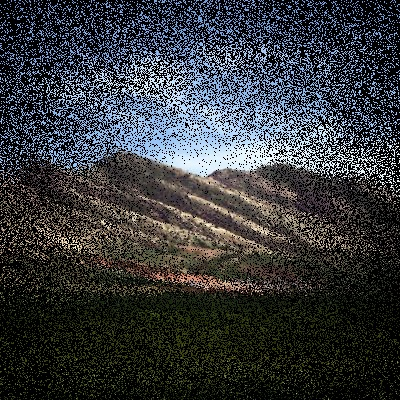

#### Function to add foveated noise to image with filling the parafoveal region.

In [35]:
def add_foveated_noise_with_fill(raw_image, eccentricity, degree_to_pixel):
    #using the eccentricity calculate the probability of correct sample in the visual angle. 
    probs = np.exp(-0.27*eccentricity)
    norm_probs = probs/np.sum(probs)
    norm_probs = norm_probs.ravel()
    
    result_r = np.empty((raw_image.shape[0], raw_image.shape[1]))
    result_g = np.empty((raw_image.shape[0], raw_image.shape[1]))
    result_b = np.empty((raw_image.shape[0], raw_image.shape[1]))
    
    #randomly sample the pixels positions.
    sampled_indexes = np.random.choice(len(norm_probs), N_SAMPLES, False, norm_probs)
    sampled_index_probs = probs.ravel()[sampled_indexes]
    indexes = sampled_indexes[sampled_index_probs > np.random.uniform(0.0,1.0,len(sampled_index_probs))]
    
    result_r.ravel()[indexes] = raw_image[:,:,0].ravel()[indexes]
    result_g.ravel()[indexes] = raw_image[:,:,1].ravel()[indexes]
    result_b.ravel()[indexes] = raw_image[:,:,2].ravel()[indexes]
    
    all_indexes = np.arange(len(norm_probs))
    remaining_indexes = np.setxor1d(all_indexes, indexes)
    index_ecc = eccentricity.ravel()[remaining_indexes]
    (row,col) = np.unravel_index(remaining_indexes, (raw_image.shape[0], raw_image.shape[1]), order='C')
    noise_offset = np.random.choice([-1,1], len(index_ecc))
    index_ecc = index_ecc * np.random.normal(0,1,len(index_ecc))
    
    row = np.clip((row + index_ecc),0,raw_image.shape[0]-1)
    col = np.clip((col + index_ecc),0,raw_image.shape[1]-1)
    row = row.astype(int)
    col = col.astype(int)
    
    noisy_index = np.ravel_multi_index((row,col), (raw_image.shape[0], raw_image.shape[1]), order='C')
    
    result_r.ravel()[remaining_indexes] = raw_image[:,:,0].ravel()[noisy_index]
    result_g.ravel()[remaining_indexes] = raw_image[:,:,1].ravel()[noisy_index]
    result_b.ravel()[remaining_indexes] = raw_image[:,:,2].ravel()[noisy_index]
    
    result = np.dstack((result_r,result_g,result_b))
    
    return result    


#### Test the function

In [36]:
start = time.time()
noisy_image = add_foveated_noise_with_fill(image, ecc, d2p)
end = time.time()
print ("Time taken to run the module %s seconds" % (end - start))

Time taken to run the module 0.1515669822692871 seconds


In [37]:
cv2.imwrite('noisy-2.jpg', noisy_image)

True

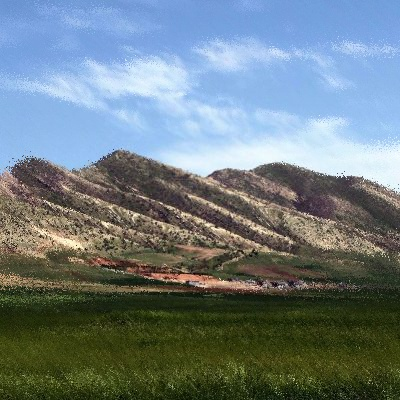